<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/post_training_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [4]:
!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 309kB/s 
     |████████████████████████████████| 2.2MB 45.6MB/s 
     |████████████████████████████████| 122kB 63.7MB/s 
     |████████████████████████████████| 3.7MB 41.6MB/s 
     |████████████████████████████████| 382.9MB 40kB/s 
  Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4
  Found existing installation: thinc 7.0.8
    Uninstalling thinc-7.0.8:
      Successfully uninstalled thinc-7.0.8
  Found existing installation: spacy 2.1.9
    Uninstalling spacy-2.1.9:
      Successfully uninstalled spacy-2.1.9


In [5]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding, decaying
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags


import itertools
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [7]:
spacy.prefer_gpu()

True

In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

#        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict

In [9]:
train_data = load_jsonl('train.jsonl')
type(train_data)

Loaded 1000 records from train.jsonl


list

In [18]:
type(en_core_web_lg)

module

In [0]:
nlp = en_core_web_lg.load()

In [10]:
model = 'en_core_web_lg'
#model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = en_core_web_lg.load()  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [11]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART',
 'beverage',
 'bread',
 'condiment',
 'dish',
 'food_habit',
 'fruit',
 'herb',
 'lifestyle',
 'meal',
 'pastry',
 'product',
 'sandwich',
 'seed',
 'spice',
 'vegetable',
 'vegetableU_spice')

In [0]:
dropout = decaying(0.6, 0.2, 1e-4)

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(250):
      random.shuffle(train_data)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=next(dropout), losses=losses)
        loss_trend.append(losses['ner'])

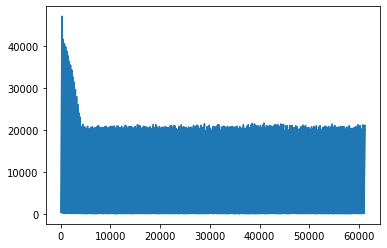

In [14]:
plt.plot(loss_trend)

In [134]:
df_pattern = pd.read_json('patterns.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
7772,U_vegetable,"[{'LOWER': 'wing'}, {'LOWER': 'bean'}]",wing_bean,wing bean,"(wing bean, U_vegetable)",{'wing bean': 'U_vegetable'}
7773,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'pepper'}]",yellow_pepper,yellow pepper,"(yellow pepper, U_vegetable)",{'yellow pepper': 'U_vegetable'}
7774,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]",yellow_zucchini,yellow zucchini,"(yellow zucchini, U_vegetable)",{'yellow zucchini': 'U_vegetable'}
7775,U_vegetable,[{'LOWER': 'zucchini'}],zucchini,zucchini,"(zucchini, U_vegetable)",{'zucchini': 'U_vegetable'}
7776,U_vegetable,[{'LOWER': 'zucchinis'}],zucchinis,zucchinis,"(zucchinis, U_vegetable)",{'zucchinis': 'U_vegetable'}


In [16]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [15]:
reviews = pd.read_csv('reviews_text.csv',usecols=['_id', 'text','overall','originality','value','nutrition','presentation','taste','dish','type','user','restaurant'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 12 columns):
_id             56156 non-null object
originality     56156 non-null int64
value           56156 non-null int64
nutrition       56156 non-null int64
presentation    56156 non-null int64
taste           56156 non-null int64
text            56155 non-null object
dish            56156 non-null object
type            56156 non-null object
user            56156 non-null object
restaurant      56156 non-null object
overall         56156 non-null float64
dtypes: float64(1), int64(5), object(6)
memory usage: 5.1+ MB


In [17]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 12 columns):
_id             56155 non-null object
originality     56155 non-null int64
value           56155 non-null int64
nutrition       56155 non-null int64
presentation    56155 non-null int64
taste           56155 non-null int64
text            56155 non-null object
dish            56155 non-null object
type            56155 non-null object
user            56155 non-null object
restaurant      56155 non-null object
overall         56155 non-null float64
dtypes: float64(1), int64(5), object(6)
memory usage: 5.6+ MB


In [20]:
reviews['user'].nunique()

5714

In [25]:
reviews['dish'].nunique()

43668

In [26]:
reviews['restaurant'].nunique()

16881

In [27]:
reviews.groupby(['user','restaurant','dish'],as_index=False)['text'].count().sort_values(by=['text'],ascending=False)

,user,restaurant,dish,text
544,59c489e73e616a0004f9bcf7,5a08f8326d62fc000456e328,5c4feb845de4510004556ddd,16
10658,5acb8f9dd5fbb40004e7a793,5c4c28a0db404600045f3372,5c4c28dddb404600045f3373,12
42319,5d3f28ffd45aa9000435db9b,5d6628871b64cf00048d6090,5d668ae51b64cf00048d6f27,10
573,59c489e73e616a0004f9bcf7,5a277fb0adeb5c0004e599d8,5a2781f1adeb5c0004e599df,9
488,59c489e73e616a0004f9bcf7,59f2d53bdc652e000489b37e,59f2d943dc652e000489b38a,9
...,...,...,...,...
18495,5bb52c0d1c6cca00048806b3,5ad0618f02994d00048ff42b,5ad061fb02994d00048ff42d,1
18496,5bb52c0d1c6cca00048806b3,5b99db50c3087d000410adbe,5bb52eba1c6cca00048806bf,1
18497,5bb52c0d1c6cca00048806b3,5bb52f8a1c6cca00048806ca,5bb530661c6cca00048806d2,1
18498,5bb5c5c21c6cca000488084b,5ab99bfe158f6d0004fcfba0,5bb5cfe81c6cca0004880858,1


In [29]:
reviews.groupby(['restaurant','user'],as_index=False)['text'].count().sort_values(by=['text'],ascending=False)

,restaurant,user,text
461,59c20f081747f4000483765d,5adaeab7b433a40004dc0259,102
16453,5c028cda3434a90004fde9a9,5d1b99f20d225d000450df53,85
539,59c20f081747f4000483765d,5c95cdd9d893940004247c9e,56
26789,5d28047889291800043a487f,5cfbf6e0a95ce3000492d4c0,55
30169,5dad6aa63b499c00209f8569,5da9242a90ae8b0020fac517,52
...,...,...,...
12786,5b672fea2fd1a7000431f14a,5cdcde41faa8b9000444c4e5,1
12784,5b672fea2fd1a7000431f14a,5bf2ba16f21e730004d3307b,1
12782,5b672fea2fd1a7000431f14a,5b3f1d52f46f500004ae0d6c,1
12781,5b672fea2fd1a7000431f14a,5ac7bf61dde05700046de152,1


In [34]:
reviews.query('user == "59c489e73e616a0004f9bcf7" & dish == "5c4feb845de4510004556ddd"')['text'][16485]


'Startup life and vegan junk food is starting to show on me and so I’ve been on a health kick and nothing could be better than my custom wrap at SaladStop. I get #sustenir kale which is hydroponic kale grown here in Singapore 🇸🇬 and a whole bunch of fresh veggies. If I could just eat like this all the time!\n\n#greeeeen #wraps #saladstop'

In [0]:
train_reviews = reviews[:1000]
eval_reviews = reviews[1000:20000]
test_reviews = reviews[20000:30000]

In [36]:
eval_docs = eval_reviews['text'][:20]

for doc in eval_docs:
  displacy.render(nlp(doc),'ent',jupyter=True)
  print([(ent.text, ent.label_, ent.ent_id_) for ent in nlp(doc).ents])

[('sauce', 'condiment', 'sauce')]


[('asparagus', 'vegetable', 'asparagus'), ('mushroom', 'vegetable', 'mushrooms')]


[('salad', 'dish', 'salad'), ('tofu', 'dish', 'tofu'), ('pomelo', 'fruit', 'pomelo'), ('corn', 'vegetable', 'corn'), ('carrots', 'vegetable', 'carrot'), ('quinoa', 'dish', 'quinoa'), ('salad', 'dish', 'salad'), ('salad', 'dish', 'salad'), ('vegan', 'lifestyle', 'vegan'), ('vegetarian', 'lifestyle', 'vegetarian')]


[('vegetarians', 'food_habit', 'vegetarians'), ('veg', 'food_habit', 'veg'), ('hot and sour soup', 'dish', 'hot_and_sour_soup'), ('fried rice', 'dish', 'fried_rice'), ('veggies', 'vegetable', 'vegetables'), ('tofu', 'dish', 'tofu'), ('egg', 'dish', 'egg'), ('dinner', 'meal', 'dinner'), ('soup', 'dish', 'soup')]


[('#crfsg', 'ORG', '#_crf')]


[('$5', 'MONEY', '$_5'), ('international day', 'DATE', ''), ('linguine', 'dish', 'linguine'), ('cashew', 'seed', 'cashew_nuts'), ('cream cheese', 'dish', 'cream_cheese'), ('spinach', 'vegetable', 'spinach'), ('spinach', 'vegetable', 'spinach'), ('20mins', 'TIME', ''), ('pasta', 'dish', 'pasta'), ('pasta', 'dish', 'pasta'), ('mins', 'TIME', 'mins')]


[('pasta', 'dish', 'pasta'), ('vegan', 'lifestyle', 'vegan'), ('pasta', 'dish', 'pasta'), ('#crf', 'ORG', '#_crf')]


[('spinach', 'vegetable', 'spinach'), ('pasta', 'dish', 'pasta'), ('#crfsg', 'ORG', '#_crf')]


[('7', 'CARDINAL', '7'), ('snack', 'meal', 'snack'), ('sauce', 'condiment', 'sauce')]


[('donut', 'pastry', 'donuts'), ('banana', 'fruit', 'banana'), ('banana', 'fruit', 'banana'), ('chocolate', 'dish', 'chocolate'), ('donut', 'pastry', 'donuts'), ('days', 'DATE', 'days'), ('donuts', 'pastry', 'donuts')]


[('Cheese', 'dish', 'cheese'), ('bread', 'bread', 'bread'), ('vegan', 'lifestyle', 'vegan'), ('grilled cheese', 'dish', 'grilled_cheese'), ('first', 'ORDINAL', 'first'), ('vegan', 'lifestyle', 'vegan'), ('non-vegan', 'lifestyle', 'non-vegan'), ('grilled cheese', 'dish', 'grilled_cheese'), ('night', 'TIME', 'night'), ('lunch', 'meal', 'lunch'), ('sandwich', 'dish', 'sandwich'), ('vegan', 'lifestyle', 'vegan'), ('sandwich', 'dish', 'sandwich'), ('Vegan cheese', 'dish', 'vegan_cheese'), ('avocado', 'fruit', 'avocado'), ('tomatoes', 'fruit', 'tomato'), ('kale', 'vegetable', 'kale'), ('balsamic drizzle', 'condiment', ''), ('bread', 'bread', 'bread'), ('vegan', 'lifestyle', 'vegan'), ('butter', 'condiment', 'butter')]


[('bread', 'bread', 'bread'), ('pumpkin', 'vegetable', 'pumpkin'), ('vegan cheese', 'dish', 'vegan_cheese'), ('veggies', 'vegetable', 'vegetables'), ('winter melon', 'fruit', 'winter_melon'), ('mushroom', 'vegetable', 'mushrooms'), ('rice', 'dish', 'rice'), ('tofu', 'dish', 'tofu'), ('kimchi', 'dish', 'kimchi'), ('vegan', 'lifestyle', 'vegan')]


[('bacon', 'dish', 'bacon')]


[('dim sum', 'dish', 'dim_sum'), ('dumpling', 'dish', 'dumpling'), ('vegan', 'lifestyle', 'vegan'), ('dumplings', 'dish', 'dumplings'), ('truffle', 'vegetable', 'truffles')]


[('kale', 'vegetable', 'kale'), ('goji berries', 'fruit', 'goji_berries')]


[('eggplant', 'vegetable', 'eggplants')]


[('vegan', 'lifestyle', 'vegan'), ('egg', 'dish', 'egg'), ('noodles', 'dish', 'noodles'), ('truffle', 'vegetable', 'truffles'), ('mushrooms', 'vegetable', 'mushrooms'), ('edamame', 'vegetable', 'edamame')]


[('tofu', 'dish', 'tofu'), ('carnivore', 'food_habit', 'carnivore'), ('silken tofu', 'dish', 'silken_tofu'), ('enoki mushrooms', 'vegetable', 'enoki_mushrooms')]


[('kale', 'vegetable', 'kale'), ('pomegranate', 'fruit', 'pomegranate'), ('seeds', 'seed', 'seeds'), ('veggie', 'vegetable', 'vegetables')]


[('dessert', 'meal', 'dessert'), ('soup', 'dish', 'soup'), ('goji berries', 'fruit', 'goji_berries')]


In [53]:
from spacy.pipeline import Tagger



spacy.pipeline.pipes.Tagger

In [19]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'ner', 'merge_entities']

In [22]:
!ls -l

total 106702
-rw------- 1 root root     2000 Dec 26 18:06  bread_keyword_patterns.npz
-rw------- 1 root root      589 Dec 26 17:27  breads_list_2.jsonl
-rw------- 1 root root    26438 Dec 26 16:44  breads_list.jsonl
-rw------- 1 root root     2269 Jan  6 19:17  checklist.txt
-rw------- 1 root root    25359 Dec 15 03:21  CoherenceScore.csv
-rw------- 1 root root     4968 Dec 26 18:06  condiment_keyword_patterns.npz
-rw------- 1 root root     2353 Dec 26 16:29  condiments_list_2.jsonl
-rw------- 1 root root    43320 Dec 26 16:21  condiments_list.jsonl
-rw------- 1 root root   596924 Jan  9 09:18 'Copy of patterns.jsonl'
-rw------- 1 root root  8428475 Dec 21 13:01  datalist_corrected.csv
-rw------- 1 root root    24864 Dec 26 17:05  df_check_breads.csv
-rw------- 1 root root    40909 Dec 26 16:21  df_check_condiments.csv
-rw------- 1 root root   185178 Dec 26 08:09  df_check_de.csv
-rw------- 1 root root  4580904 Dec 26 08:10  df_check_en.csv
-rw------- 1 root root    56341 Dec 26 09:17 

In [23]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
nlp.add_pipe(ruler, before='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
nlp.to_disk('trained_model_2020_01_14_v3')

In [0]:
nlp = spacy.blank("en")

In [142]:
nlp(eval_docs[1010])

Cheese meats bread offers a solid vegan grilled cheese option. Grilled cheeseries are hard to come across in the first place and to find a vegan option was pretty exciting. It tasted great, provided the comfort of a non-vegan grilled cheese, and it actually walked the line of late-night and healthy lunch food. I would definitely recommend it. My only wish is that they offer some of their other sandwich toppings with the vegan sandwich (you can't ask for substitutions).

Ingredients: Vegan cheese, smashed avocado, roasted tomatoes, kale, balsamic drizzle, whole wheat bread, vegan butter

In [0]:
from collections import Counter
def remove_duplicate_list_items(input_list):
  c = Counter(input_list)
  output_list = []
  for key in c.keys():
    if len(key) != 0:
      output_list.append(key)
  
  return output_list

In [60]:
l = ['carrots',
  'corn',
  'pomelo',
  'quinoa',
  'salad',
  'salad',
  'salad',
  'tofu',
  'vegan',
  'vegetarian']
Counter(l)

Counter({'carrots': 1,
         'corn': 1,
         'pomelo': 1,
         'quinoa': 1,
         'salad': 3,
         'tofu': 1,
         'vegan': 1,
         'vegetarian': 1})

In [26]:
ent_list = []
for doc in eval_reviews['text']:
#  displacy.render(nlp(doc),'ent',jupyter=True)
  ent_list.append([k  for k in Counter(sorted([(ent.ent_id_) for ent in nlp(doc).ents if ent.ent_id_ != ''])).keys()])
#ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list[-5:]

[[],
 ['cashew_nuts',
  'cheese',
  'chips',
  'corn',
  'guacamole',
  'half',
  'jalapeños',
  'jicama',
  'onion',
  'pico_de_gallo',
  'sour_cream'],
 ['nice', 'salads', 'vegetables'],
 ['bananas', 'breakfast', 'sweet_potatoes'],
 ['açaí', 'coconut', 'honey', 'nutella', 'vegan']]

In [27]:
ent_list[:5]

[['sauce'],
 ['asparagus', 'mushrooms'],
 ['carrot',
  'corn',
  'nice',
  'pomelo',
  'quinoa',
  'salad',
  'tofu',
  'vegan',
  'vegetarian'],
 ['dinner',
  'egg',
  'fried_rice',
  'hot_and_sour_soup',
  'soup',
  'tofu',
  'veg',
  'vegetables',
  'vegetarians'],
 ['center_for_responsible_future']]

In [0]:
df_entities = pd.DataFrame(pd.Series(ent_list),columns=['entities'])

In [29]:
df_entities.tail()

,entities
18995,[]
18996,"[cashew_nuts, cheese, chips, corn, guacamole, ..."
18997,"[nice, salads, vegetables]"
18998,"[bananas, breakfast, sweet_potatoes]"
18999,"[açaí, coconut, honey, nutella, vegan]"


In [30]:
eval_reviews.head()

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall
1000,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8
1001,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2
1002,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6
1003,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8
1004,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8


In [31]:
eval_reviews.reset_index(drop=True)

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall
0,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8
1,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2
2,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6
3,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8
4,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
18995,5dabcc5176bdc9002011948c,5,4,4,5,5,Super delicious but kind of pricy... kind of w...,5c8ef72a658c380004545f4f,dish,5dabcb7c76bdc90020119415,5ad8d63fc3defe00049c68ba,4.6
18996,5c8ef72a658c380004545f50,3,3,4,4,4,You might know by now I’m a nacho aficionado. ...,5c8ef72a658c380004545f4f,dish,5c085ed3e0ff8000047e3cc4,5ad8d63fc3defe00049c68ba,3.6
18997,5c8effab658c380004545fb4,5,4,5,5,5,One of the best house salads I’ve had. Nice va...,5c8effaa658c380004545fb3,dish,5c3376ee690ee90004910623,5b0f660c26555b0004f0a3a4,4.8
18998,5c8f043a658c380004545fd6,4,4,4,3,4,I’m not gonna say these are decadent with a he...,5c8f043a658c380004545fd5,dish,5c085ed3e0ff8000047e3cc4,5ad8d63fc3defe00049c68be,3.8


In [32]:
list(eval_reviews.columns) + list(df_entities.columns)

['_id',
 'originality',
 'value',
 'nutrition',
 'presentation',
 'taste',
 'text',
 'dish',
 'type',
 'user',
 'restaurant',
 'overall',
 'entities']

In [33]:
eval_new_df = pd.concat([eval_reviews.reset_index(drop=True), df_entities],axis=1,ignore_index=True)
eval_new_df.columns = list(eval_reviews.columns) + list(df_entities.columns)
eval_new_df.head()

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall,entities
0,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8,[sauce]
1,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2,"[asparagus, mushrooms]"
2,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6,"[carrot, corn, nice, pomelo, quinoa, salad, to..."
3,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8,"[dinner, egg, fried_rice, hot_and_sour_soup, s..."
4,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8,[center_for_responsible_future]


In [0]:
eval_new_df.to_csv('eval_new_graph_input.csv')

In [0]:
ent_list = []
for doc in eval_reviews['text']:
  ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])


In [37]:
df_eval = pd.DataFrame()
df_eval = df_eval.append(ent_list).dropna(how='all')

full_list_eval = []

for col in df_eval.columns:
  full_list_eval.extend([k.lower() for k in Counter(list(df_eval[col])).keys() if k != None])

full_list_eval = [k for k in Counter(sorted(full_list_eval)).keys()]
full_list_eval

['-it',
 '.75 cent',
 '1-for-1',
 '1.1',
 '1/2',
 '1/2pm',
 '1/3',
 '1/4',
 '1/8',
 '10 bucks',
 '10,000',
 '100/10',
 '1000',
 '10c',
 '11 bucks',
 '11.30am',
 '12.30pm',
 '12/10',
 '12:45am',
 '12th',
 '15 euros',
 '15/10',
 '15k',
 '15th',
 '16,00 euro',
 '16month',
 '17',
 '18',
 '190',
 '1922',
 '1:30',
 '1x',
 '2.5',
 '2.5 hour',
 '2/3',
 '2/6/18',
 '20 (',
 '20 dollars',
 '20-ounce',
 '20/10',
 '200 rupees',
 '200 yen',
 '20k',
 '20minutes',
 '20x',
 '21 dollars',
 '22',
 '24 hour',
 '255',
 '25k',
 '27',
 '27th',
 '2x',
 '2️⃣',
 '3 dollars',
 '3,000',
 '3/4',
 '313',
 '32 rupees',
 '35 dollars',
 '38',
 '4.80 euro',
 '4/10',
 '4/4',
 '45',
 '48/49',
 '48sgd',
 '4evervegan',
 '4hr',
 '50 cent',
 '50 cents',
 '50 rupees',
 '50,000',
 '50c',
 '50k',
 '50rmb',
 '52',
 '55',
 '58 dollars',
 '5cs',
 '6/10',
 '6/5',
 '60 baht',
 '60 cents',
 '60k',
 '70k',
 '80 cents',
 '880',
 '8th',
 '9',
 '9 dollars',
 '^^',
 'a dollar',
 'a good 30',
 'a tonne',
 'abalone',
 'abbotkinney',
 'about

In [38]:
len(full_list_eval)

2653

In [39]:
ent_list_test = []
for doc in test_reviews['text']:
  ent_list_test.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

df_test = pd.DataFrame()
df_test = df_test.append(ent_list_test).dropna(how='all')

full_list_test = []

for col in df_test.columns:
  full_list_test.extend([k.lower() for k in Counter(list(df_test[col])).keys() if k != None])

full_list_test = [k for k in Counter(sorted(full_list_test)).keys()]
full_list_test

['1-for-1',
 '1/2',
 '1/3',
 '1/4',
 '10 dollars',
 '100/10',
 '1000',
 '108 eatery',
 '11.30am',
 '11:30',
 '11th',
 '12.30',
 '12k',
 '14 euro',
 '15 dollars',
 '15000won',
 '15th',
 '15th day',
 '18 bucks',
 '1for1',
 '2.50',
 '200 yuan',
 '200gr',
 '20min',
 '21',
 '22',
 '22nd',
 '24',
 '241',
 '24h',
 '25p',
 '25₹',
 '27',
 '280,000',
 '29th',
 '2x',
 '3 dollars',
 '3/4',
 '30 bucks',
 '3pcs',
 '40 cents',
 '40k',
 '45',
 '48rmb',
 '49 reais',
 '4evervegan',
 '5-spice',
 '5.5 hour',
 '50 cents',
 '50hkd',
 '50p',
 '50¢ coin',
 '53hkd',
 '6/5',
 '60%-70',
 '648',
 '6pcs',
 '6th',
 '7-up',
 '75 cents',
 '7th',
 '80%-90',
 '800 yen',
 '85k',
 '9 bucks',
 '^^',
 'a dollar',
 'a tonne',
 'abobrinha',
 'about 30',
 'abóbora',
 'accidentallyvegan',
 'accompagnata',
 'accompagnato',
 'acia',
 'acompanha',
 'acompañado',
 'activa',
 'adai',
 'adaptar',
 'aderezo',
 'advocado',
 'adzuki',
 'afghan',
 'african',
 'aglio',
 'agrandado',
 'ahlian',
 'ajillo',
 'ajo negro',
 'albóndigas',
 'al

In [43]:
entities_to_be_added = [k for k in Counter(sorted(full_list_eval + full_list_test)).keys()]
len(entities_to_be_added)

3779

In [0]:
import json

with open('entities_to_be_added_test.txt', 'w') as f:
    f.write(json.dumps(entities_to_be_added))

In [0]:
df = pd.DataFrame()
df =df.append(ent_list).dropna(how='all')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 4 to 996
Data columns (total 11 columns):
0     303 non-null object
1     107 non-null object
2     43 non-null object
3     15 non-null object
4     7 non-null object
5     3 non-null object
6     2 non-null object
7     2 non-null object
8     2 non-null object
9     1 non-null object
10    1 non-null object
dtypes: object(11)
memory usage: 28.4+ KB


In [132]:
[k for k in Counter(list(df[2])).keys() if k != None]

['croissants',
 'Gujarati',
 'Rajasthani',
 'Native Bowl',
 'Fremantle',
 'Swiss',
 'shakshuka',
 'Kona Joe',
 'Ahmedabad',
 'Shangrila',
 'Pili',
 'Les Chottes',
 'Verbier',
 'berries',
 'buffet',
 'Stockholm',
 'Nadu',
 'SUFOOD',
 'poached',
 'Kaedama',
 'dosas',
 'Kaveri',
 'crepes',
 'oat',
 '8️⃣',
 'peppercorns',
 '9',
 'deep fried & coated',
 'Hokkien',
 'Bangkok',
 'creme',
 'palak',
 'choc',
 'mac &',
 'calzones',
 'Nasi Goreng',
 'natto',
 '10 euros',
 'donación',
 'Central kitchen']

In [156]:
full_list = []

for col in df.columns:
  full_list.extend([k.lower() for k in Counter(list(df[col])).keys() if k != None])

([k for k in Counter(sorted(full_list)).keys()])

354

In [0]:
len(full_list)
import json

with open('entities_to_be_added.txt', 'w') as f:
    f.write(json.dumps(full_list))


In [46]:
doc2 = nlp("Avocado 🌿 is good but Indian cuising such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")
displacy.render(doc2,'ent',jupyter=True)

print([(ent.text, ent.label_, ent.ent_id_) for ent in doc2.ents])

[('Avocado', 'fruit', 'avocado'), ('Indian', 'NORP', 'indian'), ('chicken tikka masala', 'dish', 'chicken_tikka_masala'), ('paneer tikka masala', 'dish', 'paneer_tikka_masala'), ('sweet potato fries', 'dish', 'sweet_potato_fries'), ('Egypt', 'GPE', 'egypt'), ('India', 'GPE', 'india')]


In [45]:
eval_new_df.describe()

,originality,value,nutrition,presentation,taste,overall
count,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000,19000.000000
mean,4.278474,4.217947,4.082632,4.426474,4.495895,4.300305
std,0.931396,0.923475,0.984491,0.799076,0.804603,0.693492
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000
50%,5.000000,4.000000,4.000000,5.000000,5.000000,4.400000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [46]:
for doc in nlp.pipe(eval_reviews['text'][-5:]):
  displacy.render(doc,style='dep',jupyter=True)
  for token in doc:
    print(token.text,'...',token.dep_)

Super ... advmod
delicious ... amod
but ... cc
kind ... advmod
of ... advmod
pricy ... conj
... ... punct
kind ... advmod
of ... advmod
worth ... ROOT
it ... dobj
though ... mark
it ... nsubj
’s ... advcl
a ... det
huge ... amod
plate ... attr
haha ... ROOT


You ... nsubj
might ... aux
know ... ROOT
by ... prep
now ... advmod
I ... nsubj
’m ... ccomp
a ... det
nacho ... compound
aficionado ... attr
. ... punct
A ... det
“ ... punct
nachonado ... ROOT
, ... punct
” ... punct
if ... mark
you ... nsubj
will ... advcl
. ... punct
This ... nsubj
is ... ROOT
“ ... punct
SunChorizo ... attr
, ... punct
nacho ... compound
cheese ... conj
, ... punct
guacamole ... conj
, ... punct
pico de gallo ... conj
, ... punct
jalapeño ... conj
, ... punct
green ... amod
onion ... conj
, ... punct
cashew ... nmod
sour cream ... conj
with ... prep
choice ... pobj
of ... prep
raw ... amod
thin ... advmod
- ... punct
sliced ... amod
jicama ... nmod
" ... punct
chips ... pobj
" ... punct
or ... cc
baked ... amod
corn ... compound
chips ... conj
. ... punct
” ... punct
Or ... cc
you ... nsubj
can ... aux
get ... ROOT
half ... amod
corn ... compound
chips ... dobj
and ... cc
half ... compound
jicama ... conj
as ... mark
shown ... advcl
here ... advmod
. ... punct
Th

One ... ROOT
of ... prep
the ... det
best ... amod
house ... compound
salads ... pobj
I ... nsubj
’ve ... aux
had ... relcl
. ... punct
Nice ... amod
variety ... ROOT
of ... prep
fresh ... amod
veggies ... pobj
. ... punct


I ... nsubj
’m ... aux
not ... neg
gon ... ROOT
na ... aux
say ... xcomp
these ... nsubj
are ... ccomp
decadent ... acomp
with ... prep
a ... det
healthy ... amod
twist ... pobj
because ... mark
I ... nsubj
’m ... advcl
not ... neg
positive ... acomp
you ... nsubj
’re ... aux
going ... ROOT
to ... aux
catch ... xcomp
the ... det
sweet potatoes ... dobj
coming ... acl
on ... prep
strong ... advcl
. ... punct
But ... ROOT
if ... mark
a ... det
sweet ... amod
breakfast ... nsubj
is ... advcl
your ... poss
thing ... attr
you ... nsubj
should ... aux
give ... relcl
them ... dative
a ... det
try ... dobj
. ... punct
Personally ... advmod
I ... nsubj
’d ... aux
serve ... ROOT
these ... dobj
with ... prep
caramelized ... amod
bananas ... pobj
or ... cc
something ... conj
to ... aux
make ... advcl
them ... nsubj
a ... det
tiny ... amod
bit ... npadvmod
more ... advmod
special ... ccomp
. ... punct


This ... det
dish ... nsubj
was ... ROOT
amazing ... acomp
! ... punct
I ... nsubj
love ... ROOT
how ... advmod
they ... nsubj
have ... ccomp
the ... det
coconut ... compound
glaze ... compound
coating ... dobj
over ... prep
the ... det
açaí ... pobj
. ... punct
The ... det
consistency ... nsubj
of ... prep
their ... poss
açaí ... pobj
is ... ROOT
perfect ... acomp
. ... punct
If ... mark
you ... nsubj
’re ... advcl
vegan ... acomp
, ... punct
make ... ROOT
sure ... acomp
to ... aux
ask ... xcomp
for ... prep
your ... poss
bowl ... pobj
without ... prep
honey ... pobj
or ... cc
Nutella ... conj
! ... punct


In [0]:
# credit - analytics vidhya https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [185]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [187]:
get_entities("Avocado 🌿 is good but Indian cuisine such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")

['such  sweet potato fries', 'Egypt']

In [198]:
eval_new_df['text'][5]

'$10.90, but got it for $5 during the international day of peace disc! honestly for $10.90 it’s pretty expensive so I probably wouldn’t get this usually. anyway quite good though! linguine in cashew nut cream cheese and spinach, super flavourful and you can’t taste the spinach at all:o not sure how to describe the taste actually bc ive never tried anything like it😂 in a good way! \nalso I waited 35 MINUTES for this which is honestly too long... the place wasn’t super full for them to be so busy, and the person who sat beside me that came 20mins after me and also ordered a pasta had his pasta come in 10 mins and mine came after his... and it was only after I asked, them it was served like immediately so I was just wondering where it was sitting this entire time:/ but it still came hot so that was ok! the taste compensated I guess haha'

In [192]:
nlp(eval_new_df['text'][5]).ents

($5,
 linguine,
 cashew,
 cream cheese,
 spinach,
 spinach,
 20mins,
 pasta,
 pasta,
 mins)

In [0]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [199]:
doc = nlp(eval_new_df['text'][5])
displacy.render(doc,style='dep',jupyter=True)
for token in doc:
  print(token.text,'...',token.dep_)

$ ... nmod
10.90 ... ROOT
, ... punct
but ... cc
got ... conj
it ... dobj
for ... prep
$5 ... pobj
during ... prep
the ... det
international ... amod
day ... pobj
of ... prep
peace ... compound
disc ... pobj
! ... punct
honestly ... advmod
for ... ROOT
$ ... nmod
10.90 ... pobj
it ... nsubj
’s ... ROOT
pretty ... advmod
expensive ... acomp
so ... advmod
I ... nsubj
probably ... advmod
would ... aux
n’t ... neg
get ... ROOT
this ... dobj
usually ... advmod
. ... punct
anyway ... ROOT
quite ... advmod
good ... amod
though ... advmod
! ... punct
linguine ... ROOT
in ... prep
cashew ... compound
nut ... compound
cream cheese ... pobj
and ... cc
spinach ... conj
, ... punct
super ... advmod
flavourful ... amod
and ... cc
you ... nsubj
ca ... aux
n’t ... neg
taste ... ROOT
the ... det
spinach ... dobj
at ... advmod
all ... advmod
: ... punct
o ... intj
not ... neg
sure ... ROOT
how ... advmod
to ... aux
describe ... xcomp
the ... det
taste ... dobj
actually ... advmod
bc ... ROOT
i ... nsubj

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [205]:
doc = nlp(eval_new_df['text'][5])
matcher = Matcher(nlp.vocab)
#define the pattern 
pattern = [{'DEP':'ROOT'}, 
          {'DEP':'prep','OP':"?"},
          {'DEP':'agent','OP':"?"},  
          {'POS':'ADJ','OP':"?"}] 

matcher.add("matching_1", None, pattern) 

matches = matcher(doc)
len(matches)

20

In [208]:
for (id, start, end) in matches:
  print(doc[start:end].text)

10.90
for
’s
get
anyway
linguine
linguine in
taste
sure
bc
tried
😂
in
waited
was
was
wondering
came
came hot
guess


In [0]:
user_id_list = list(eval_new_df['user'].unique())
u_ids = ['u'+str(item) for item in list(np.linspace(0,len(user_id_list)-1,len(user_id_list),dtype='int'))]

user_map_dict = {}

for id_, u_id in zip(user_id_list, u_ids):
  user_map_dict[id_] = u_id

dish_id_list = list(eval_new_df['dish'].unique())
d_ids = ['d'+str(item) for item in list(np.linspace(0,len(dish_id_list)-1,len(dish_id_list),dtype='int'))]

dish_map_dict = {}

for id_, d_id in zip(dish_id_list, d_ids):
  dish_map_dict[id_] = d_id

rest_id_list = list(eval_new_df['restaurant'].unique())
r_ids = ['r'+str(item) for item in list(np.linspace(0,len(rest_id_list)-1,len(rest_id_list),dtype='int'))]

rest_map_dict = {}

for id_, r_id in zip(rest_id_list, r_ids):
  rest_map_dict[id_] = r_id

In [60]:
eval_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
_id             1000 non-null object
originality     1000 non-null int64
value           1000 non-null int64
nutrition       1000 non-null int64
presentation    1000 non-null int64
taste           1000 non-null int64
text            1000 non-null object
dish            1000 non-null object
type            1000 non-null object
user            1000 non-null object
restaurant      1000 non-null object
overall         1000 non-null float64
entities        1000 non-null object
dtypes: float64(1), int64(5), object(7)
memory usage: 101.7+ KB


In [65]:
eval_new_df['user_remapped'] = eval_new_df['user'].map(user_map_dict) 
eval_new_df['dish_remapped'] = eval_new_df['dish'].map(dish_map_dict) 
eval_new_df['rest_remapped'] = eval_new_df['restaurant'].map(rest_map_dict) 
eval_new_df.head()

,_id,originality,value,nutrition,presentation,taste,text,dish,type,user,restaurant,overall,entities,user_remapped,dish_remapped,rest_remapped
0,5a5e06be72aeaa00048cc4c8,4,3,4,4,4,The way the dish was presented was so differen...,5a5e06bc72aeaa00048cc4c7,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.8,[sauce],u0,d0,r0
1,5a5e078772aeaa00048cc4cc,2,3,4,3,4,Off the menu and they added asparagus and mush...,5a5e078572aeaa00048cc4cb,dish,5a1a2eb0ee33f1000472ace3,5a3722f0587eb70004fab2e1,3.2,"[asparagus, mushrooms]",u0,d1,r0
2,5a5eb04672aeaa00048cc505,5,4,5,4,5,Overall good salad that was healthy and hadn’t...,5a5eb04472aeaa00048cc504,dish,59d98c55ded2bc0004210661,5a08f8336d62fc000456e32f,4.6,"[carrot, corn, pomelo, quinoa, salad, tofu, ve...",u1,d2,r1
3,5a5f4c94935a8a0004fc9e75,2,3,3,3,3,Not much choices for vegetarians but they do h...,5a5f4c4e935a8a0004fc9e6f,dish,5a1a2eb0ee33f1000472ace3,59faa363f85af800044811a5,2.8,"[dinner, egg, fried_rice, hot_and_sour_soup, s...",u0,d3,r2
4,5a602755935a8a0004fc9e89,5,5,5,5,4,So colorful. So much variety. I especially lik...,5a602753935a8a0004fc9e88,dish,59ec22d177466d00048bb2e2,5a0883fc6d62fc000456e323,4.8,[#_crf],u2,d4,r3


In [0]:
eval_new_df.to_csv('eval_df_user_dish_restaurant.csv')

In [0]:
import networkx as nx
G = nx.Graph()

In [106]:
df_graph_anal = eval_new_df[['user_remapped','dish_remapped','rest_remapped','overall','entities']]
df_graph_anal.head()

,user_remapped,dish_remapped,rest_remapped,overall,entities
0,u0,d0,r0,3.8,[sauce]
1,u0,d1,r0,3.2,"[asparagus, mushrooms]"
2,u1,d2,r1,4.6,"[carrot, corn, pomelo, quinoa, salad, tofu, ve..."
3,u0,d3,r2,2.8,"[dinner, egg, fried_rice, hot_and_sour_soup, s..."
4,u2,d4,r3,4.8,[#_crf]


KeyError: ignored

In [0]:
df_user_rest = df_graph_anal[['user_remapped','rest_remapped','overall']]
df_user_rest.columns = ['source','target','weight']
df_user_rest.head()




df_user_dish = df_graph_anal[['user_remapped','dish_remapped','overall']]
df_user_dish.columns = ['source','target','weight']

df_dish_rest = df_graph_anal[['dish_remapped','rest_remapped','overall']]
df_dish_rest.columns = ['source','target','weight']

In [67]:
df_graph_exploded = df_graph_anal.explode('entities').reset_index(drop=True)
df_graph_exploded.head(10)

,user_remapped,dish_remapped,rest_remapped,overall,entities
0,u0,d0,r0,3.8,sauce
1,u0,d1,r0,3.2,asparagus
2,u0,d1,r0,3.2,mushrooms
3,u1,d2,r1,4.6,carrot
4,u1,d2,r1,4.6,corn
5,u1,d2,r1,4.6,pomelo
6,u1,d2,r1,4.6,quinoa
7,u1,d2,r1,4.6,salad
8,u1,d2,r1,4.6,tofu
9,u1,d2,r1,4.6,vegan


In [54]:
df_graph_exploded.groupby(['entities'],as_index=False)['user'].agg('count').sort_values(['user'],ascending=False)

,entities,user
742,vegan,259
602,sauce,118
747,vegetables,100
454,mushrooms,76
590,salad,64
...,...,...
507,patra,1
219,crostini,1
222,cumin,1
501,passionfruit,1


In [72]:
df_graph_anal.groupby(['user_remapped'],as_index=False)['overall'].count()

,user_remapped,overall
0,u0,155
1,u1,22
2,u10,5
3,u100,8
4,u101,1
...,...,...
225,u95,1
226,u96,2
227,u97,3
228,u98,1


In [0]:
import matplotlib.pyplot as plt

In [0]:
G = nx.from_pandas_edgelist(df_graph_anal,'user_remapped','dish_remapped',edge_attr=True)


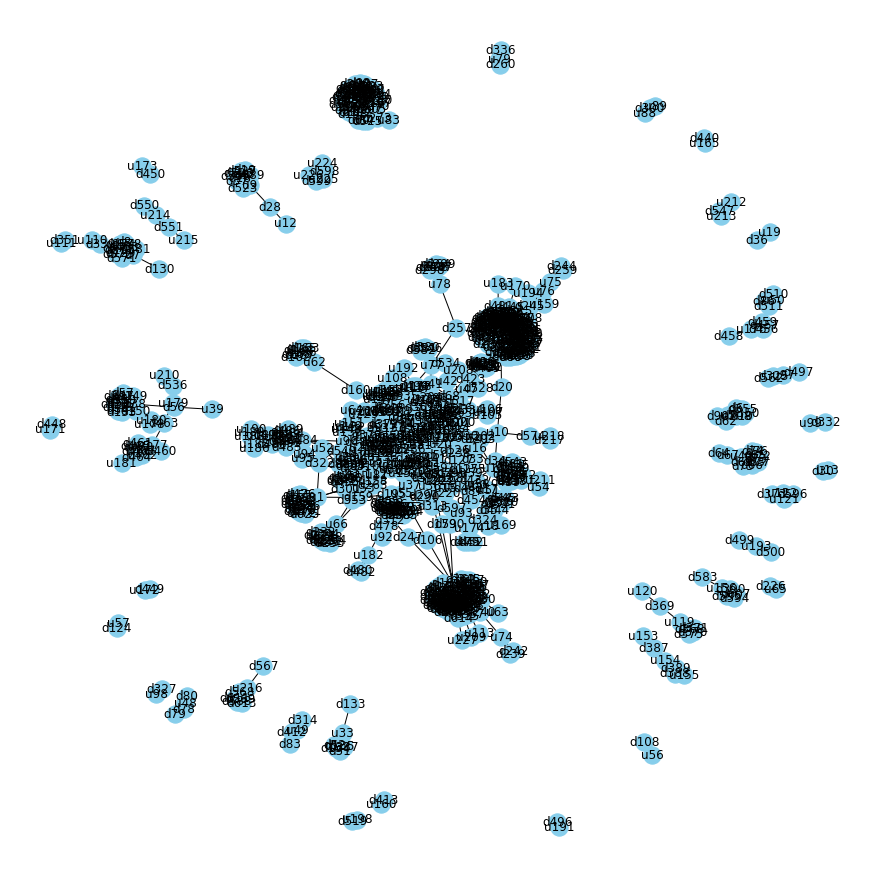

In [71]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

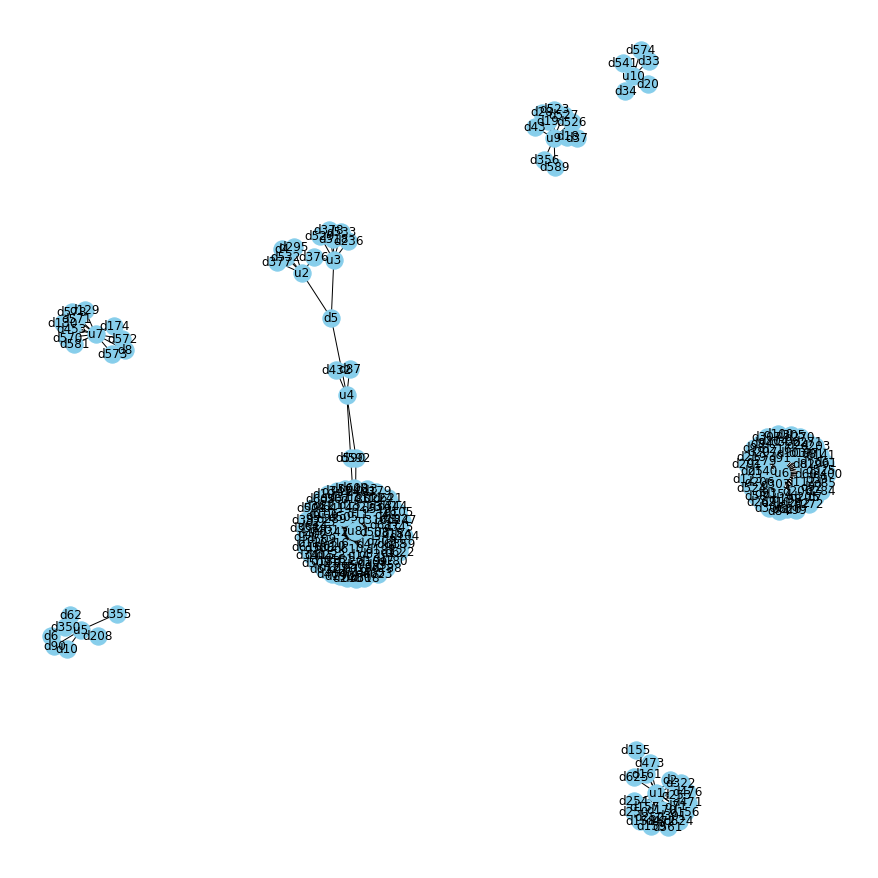

In [87]:
H = nx.from_pandas_edgelist(df_graph_anal.query('user_remapped in ["u1","u2","u3","u4","u5","u6","u7","u8","u9","u10" ]'),'user_remapped','dish_remapped',edge_attr=True)
plt.figure(figsize=(12,12))

pos = nx.spring_layout(H)
#pos = nx.spectral_layout(G)
nx.draw(H, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [109]:
df_user_rest.head()

,source,target,weight
0,u0,r0,3.8
1,u0,r0,3.2
2,u1,r1,4.6
3,u0,r2,2.8
4,u2,r3,4.8


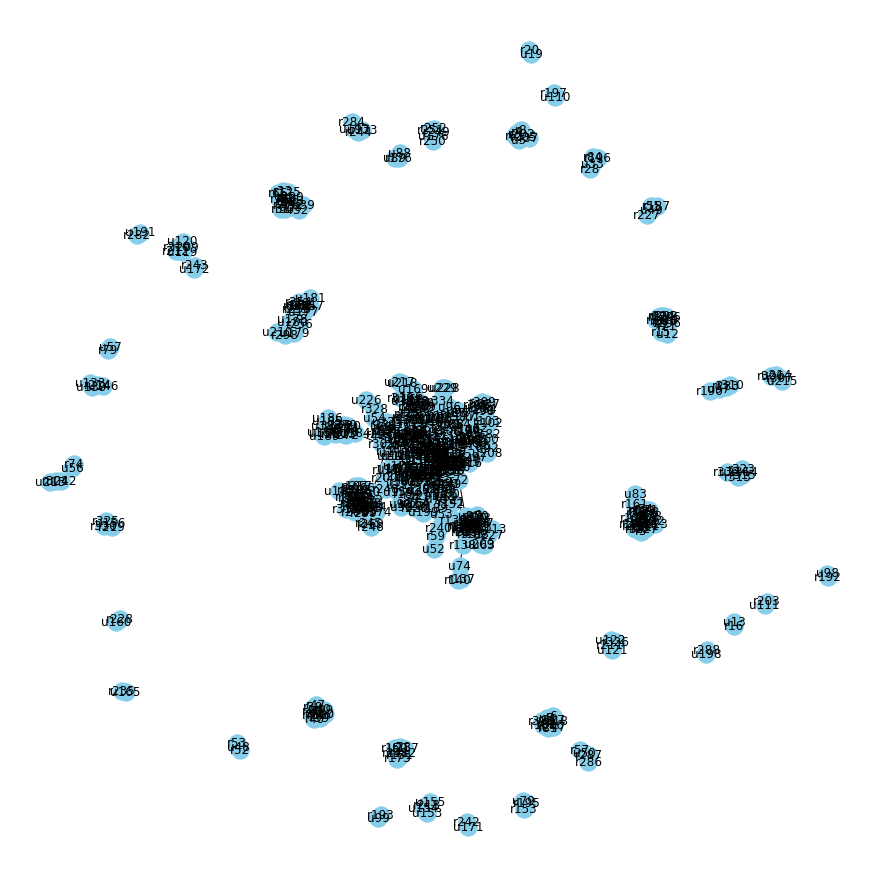

In [125]:
user_rest = nx.from_pandas_edgelist(df_user_rest,'source','target',['weight'])
plt.figure(figsize=(12,12))

pos = nx.spring_layout(user_rest)
#pos = nx.spectral_layout(G)
nx.draw(user_rest, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos,edge_labels=True)
plt.show()

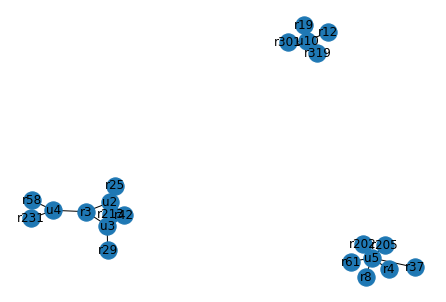

In [115]:
nx.draw(user_rest,with_labels=True,edge_labels=True)

In [126]:
# some properties
print("node degree clustering")
for v in nx.nodes(user_rest):
    print('%s %d %f' % (v, nx.degree(user_rest, v), nx.clustering(user_rest, v)))

node degree clustering
u0 45 0.000000
r0 1 0.000000
u1 15 0.000000
r1 1 0.000000
r2 1 0.000000
u2 4 0.000000
r3 5 0.000000
u3 4 0.000000
u4 3 0.000000
u5 6 0.000000
r4 1 0.000000
u6 29 0.000000
r5 1 0.000000
u7 9 0.000000
r6 1 0.000000
u8 32 0.000000
r7 1 0.000000
r8 1 0.000000
r9 1 0.000000
u9 10 0.000000
r10 1 0.000000
r11 1 0.000000
u10 4 0.000000
r12 2 0.000000
u11 11 0.000000
r13 1 0.000000
r14 1 0.000000
u12 1 0.000000
r15 2 0.000000
u13 1 0.000000
r16 1 0.000000
r17 1 0.000000
r18 1 0.000000
u14 2 0.000000
r19 6 0.000000
u15 3 0.000000
u16 2 0.000000
u17 10 0.000000
u18 1 0.000000
u19 1 0.000000
r20 1 0.000000
r21 1 0.000000
r22 1 0.000000
r23 1 0.000000
u20 4 0.000000
r24 3 0.000000
u21 3 0.000000
u22 8 0.000000
u23 1 0.000000
r25 19 0.000000
u24 1 0.000000
u25 2 0.000000
u26 4 0.000000
u27 3 0.000000
u28 2 0.000000
u29 4 0.000000
u30 6 0.000000
u31 8 0.000000
u32 2 0.000000
r26 1 0.000000
r27 1 0.000000
u33 3 0.000000
r28 1 0.000000
u34 2 0.000000
r29 24 0.000000
u35 7 0.00000

node degree clustering
0 5 0.600000
1 2 0.000000
2 5 0.400000
3 5 0.600000
4 5 0.200000
5 1 0.000000
6 3 0.000000
7 5 0.700000
8 5 0.400000
9 4 0.166667
0 8 9 7 3 2
1 4 5
2 6 3 7 4
3 9 8 7
4 8 7 9
5
6 9 8
7 8
8
9


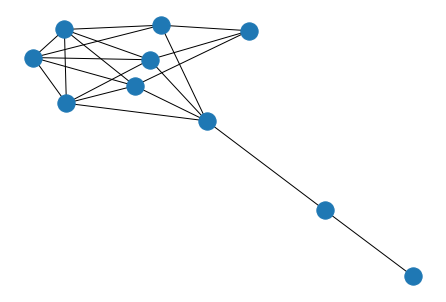

In [127]:
n = 10  # 10 nodes
m = 20  # 20 edges

G = nx.gnm_random_graph(n, m)

# some properties
print("node degree clustering")
for v in nx.nodes(G):
    print('%s %d %f' % (v, nx.degree(G, v), nx.clustering(G, v)))

# print the adjacency list
for line in nx.generate_adjlist(G):
    print(line)

nx.draw(G)
plt.show()

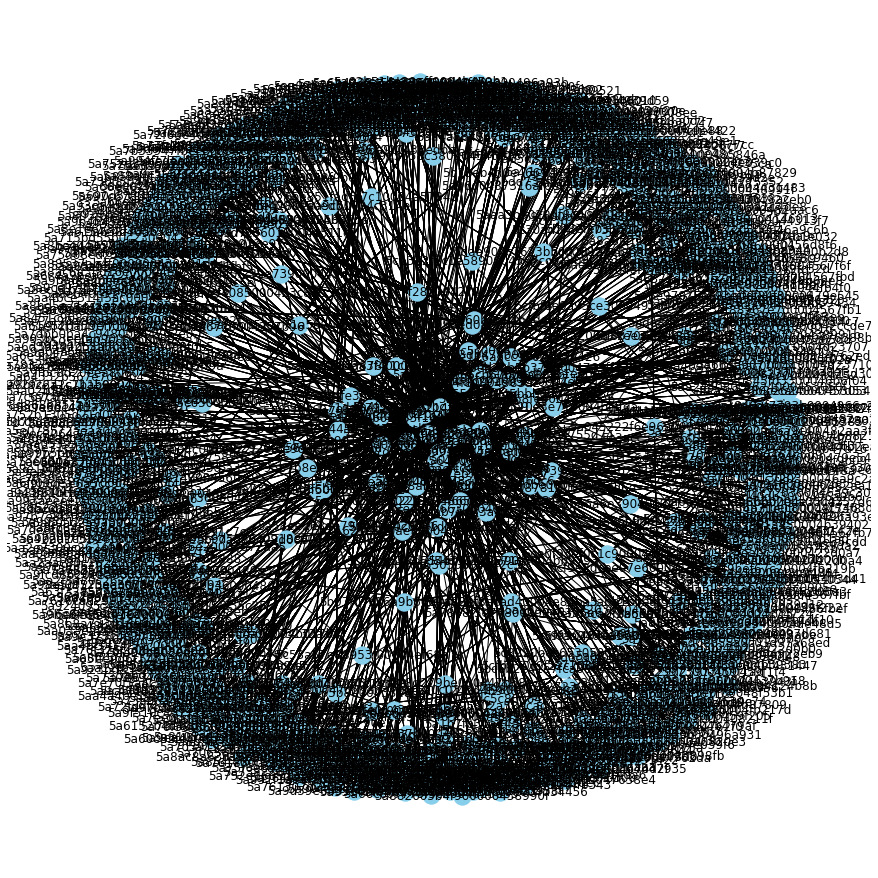

In [58]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [60]:
df_graph_exploded.query('entities == "mushrooms"')

,user,dish,overall,entities
2,5a1a2eb0ee33f1000472ace3,5a5e078572aeaa00048cc4cb,3.2,mushrooms
57,5a4f34be991bc70004e1e3a9,5a613a56d40db3000496a927,4.4,mushrooms
76,5a4f34be991bc70004e1e3a9,5a615414d40db3000496a941,5.0,mushrooms
222,5cfbf6e0a95ce3000492d4c0,5a6372dc567e7d0004567f7b,3.2,mushrooms
229,59b0a60c3c31d00004d97fa2,5a6372dc567e7d0004567f7b,4.6,mushrooms
...,...,...,...,...
4250,5aa084f7eabc7a000422d085,5aa08573eabc7a000422d094,4.4,mushrooms
4261,5a58f61b8de79b000442d5e0,5aa09e79eabc7a000422d0a0,4.2,mushrooms
4283,5c0df4052bffe30004ba99ba,5aa0d56bafdddd0004124b24,4.6,mushrooms
4458,5a1a2eb0ee33f1000472ace3,5aa488d114f5ac00044313f3,2.4,mushrooms


In [73]:
G.number_of_edges()
G.number_of_nodes()

857

In [0]:
H=nx.from_pandas_edgelist(df_graph_exploded.query('entities == "mushrooms"'),'user','dish',edge_attr=True)

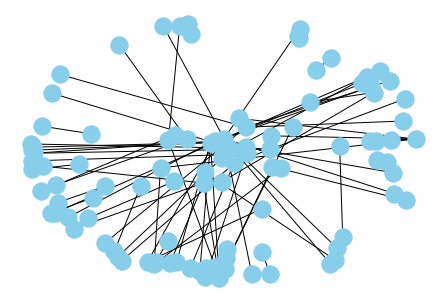

In [65]:
nx.draw(H, with_labels=False, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)

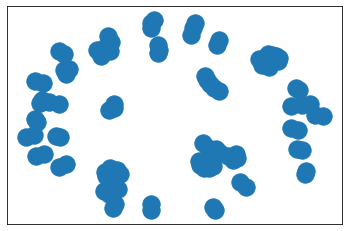

In [74]:
nx.draw_networkx_nodes(H,nx.spring_layout(H), with_labels=True)

In [0]:
U=nx.from_pandas_edgelist(df_graph_exploded[:100],'user','dish',edge_attr=True,)

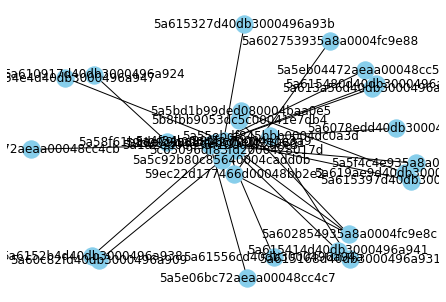

In [89]:
nx.draw(U, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)

In [0]:
X = nx.Graph()

In [94]:
node_weights_list = []
for u, v, w in zip(list(df_graph_exploded['user']),list(df_graph_exploded['dish']),list(df_graph_exploded['overall'])):
  node_weights_list.append((u,v,w))

node_weights_list


[('5a1a2eb0ee33f1000472ace3', '5a5e06bc72aeaa00048cc4c7', 3.8),
 ('5a1a2eb0ee33f1000472ace3', '5a5e078572aeaa00048cc4cb', 3.2),
 ('5a1a2eb0ee33f1000472ace3', '5a5e078572aeaa00048cc4cb', 3.2),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', 4.6),
 ('5a1a2eb0ee33f1000472ace3', '5a5f4c4e935a8a0004fc9e6f', 2.8),
 ('5a1a2eb0ee33f1000472ace3', '5a5f4c4e935a8a0004fc9e6f', 2.8),
 ('5a1a2eb0ee33f1000472ace3', '5a5f4c4e935a8a0004fc9e6f', 2.8),
 ('5a1a2eb0ee33f1000472ace3', '5a5f4c4e935a8a0004fc9e6f', 2.8),
 ('5a1a2eb0ee33f1000472ace3', '5a5f4c4e9

In [0]:
X = nx.Graph()
X.add_weighted_edges_from(node_weights_list[:20])

In [108]:
X.nodes

NodeView(('5a1a2eb0ee33f1000472ace3', '5a5e06bc72aeaa00048cc4c7', '5a5e078572aeaa00048cc4cb', '59d98c55ded2bc0004210661', '5a5eb04472aeaa00048cc504', '5a5f4c4e935a8a0004fc9e6f'))

In [113]:
[X.neighbors('5a1a2eb0ee33f1000472ace3').keys()]


AttributeError: ignored

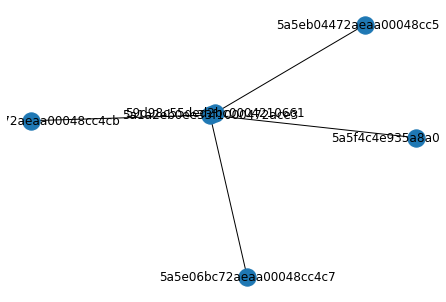

In [104]:
nx.draw(X,pos=,with_labels=True)

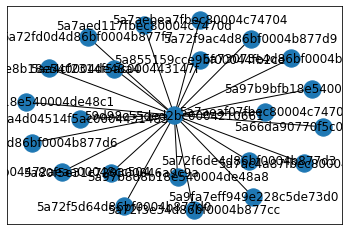

In [78]:
nx.draw_networkx(U,pos=nx.spring_layout(U),width='')